In [48]:
import numpy as np
import pandas as pd

log_pr_file = './log_price.df'
volu_usd_file = './volume_usd.df'

log_pr = pd.read_pickle(log_pr_file)
volu = pd.read_pickle(volu_usd_file)

daylen = 10

def interpolate(log_pr, volu, window=30):
    log_pr.columns = ['log_pr_%d'%i for i in range(10)]
    volu.columns = ['volu_%d'%i for i in range(10)]

    open_ = log_pr[::window].reindex(log_pr.index).ffill()
    open_.columns = ['open_%d'%i for i in range(10)]
    close_ = log_pr[window-1::window].reindex(log_pr.index).bfill()
    close_.columns = ['close_%d'%i for i in range(10)]
    high_ = log_pr.groupby(np.arange(len(log_pr))//window) \
            .max().set_index(np.arange(0, len(log_pr), window)) \
            .reindex(np.arange(len(log_pr))).ffill().set_index(log_pr.index)
    high_.columns = ['high_%d'%i for i in range(10)]
    low_ = log_pr.groupby(np.arange(len(log_pr))//window) \
            .min().set_index(np.arange(0, len(log_pr), window)) \
            .reindex(np.arange(len(log_pr))).ffill().set_index(log_pr.index)
    low_.columns = ['low_%d'%i for i in range(10)]
    return pd.concat([log_pr, volu, open_, close_, high_, low_], axis=1)

# data = interpolate(log_pr, volu, daylen)

In [49]:
# Simple Moving Average
def SMA(x, window):
    return x.rolling(window).mean()

# exponential moving average
def EMA(x, window):
    return x.ewm(com=1/window, adjust=True, min_periods=window).mean()

# Average True Range
def ATR(x, window, daylen):
    low = x[['low_%d'%i for i in range(10)]].iloc[::daylen].copy()
    high = x[['high_%d'%i for i in range(10)]].iloc[::daylen].copy()
    close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    
    high_low = high.values - low.values
    high_close = np.abs(high.values - close.shift().values)
    low_close = np.abs(low.values - close.shift().values)

    ranges = np.stack([high_low, high_close, low_close], axis=0)
    true_range = np.max(ranges, axis=0)
    true_range = pd.DataFrame(true_range, 
                              index=close.index, columns=['atr_%d'%i for i in range(10)])
    atr = EMA(true_range, window)
    atr = atr.reindex(x.index).ffill()
    return atr

# TODO
# Average Directional Movement Index
def ADX(x, window, daylen):
    low = x[['low_%d'%i for i in range(10)]].iloc[::daylen].copy()
    high = x[['high_%d'%i for i in range(10)]].iloc[::daylen].copy()
    close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    atr = ATR(x, window, daylen).iloc[::daylen]
#     print(atr)
    
    plus_di = (100 * EMA(plus_dm, window) / atr.values).values
    minus_di = abs(100 * EMA(minus_dm, window) / atr.values).values
    
    adx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = pd.DataFrame(adx, index=close.index, columns=['adx_%d'%i for i in range(10)])
    adx = ((adx.shift() * (window - 1)) + adx) / window
    adx_smooth = EMA(adx, window)
    adx_smooth = adx_smooth.reindex(x.index).ffill()
    return adx_smooth

# Commodity Channel Index
def CCI(x, window, daylen):
    low = x[['low_%d'%i for i in range(10)]].iloc[::daylen].copy()
    high = x[['high_%d'%i for i in range(10)]].iloc[::daylen].copy()
    close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    
    m = (high.values + low.values + close)/3
#     return m
    sma = SMA(m, window)
#     return sma
    mad_ = m.rolling(window).apply(lambda x: pd.Series(x).mad())
    cci = pd.DataFrame((m.values - sma.values)/(0.015*mad_.values), 
                       index=close.index, columns=['cci_%d'%i for i in range(10)])
    cci = cci.reindex(x.index).ffill()
    return cci

# Price Rate of Change
def ROC(x, window, daylen):
    close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    roc = close.pct_change(window)
    roc.columns = ['roc_%d'%i for i in range(10)]
    roc = roc.reindex(x.index).ffill()
    return roc

# Relative Strength Index
def RSI(x, window, daylen, ema=True):
    close = x[['close_%d'%i for i in range(10)]].iloc[::daylen].copy()
    
    # Make two series: one for lower closes and one for higher closes
    up = close.diff().clip(lower=0)
    down = -1 * close.diff().clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = EMA(up, window)
        ma_down = EMA(down, window)
    else:
        # Use simple moving average
        ma_up = SMA(up, window)
        ma_down = SMA(down, window)
        
    rsi = ma_up.values / (ma_down.values + 1e-4)
    rsi = 100 - (100/(1 + rsi))
    rsi = pd.DataFrame(rsi, index=close.index, columns=['rsi_%d'%i for i in range(10)])
    rsi = rsi.reindex(x.index).ffill()
    return rsi

# William's %R oscillator
def WR(x, window):
    hn = x[['log_pr_%d'%i for i in range(10)]].rolling(window).max()
    ln = x[['log_pr_%d'%i for i in range(10)]].rolling(window).min()
    wr = 100*(hn.values - x[['close_%d'%i for i in range(10)]].values)/(hn.values - ln.values)
    return pd.DataFrame(wr, index=x.index, columns=['wr_%d'%i for i in range(10)])

# Stochastic K
def SK(x, window):
    hhn = x[['high_%d'%i for i in range(10)]].rolling(window).max()
    lln = x[['low_%d'%i for i in range(10)]].rolling(window).min()
    sk = 100*(x[['close_%d'%i for i in range(10)]].values - lln.values)/(hhn.values - lln.values)
    return pd.DataFrame(sk, index=x.index, columns=['sk_%d'%i for i in range(10)])

# Stochastic D
def SD(x, window):
    sd = EMA(SK(x, window), 3)
    sd.columns = ['sd_%d'%i for i in range(10)]
    return sd
    

In [90]:
# feature generation pipline
def generate_features(data, window, daylen):
    pr = data.drop(labels=['volu_%d'%i for i in range(10)], axis=1)
    sma = SMA(pr[['log_pr_%d'%i for i in range(10)]], window)
    sma.columns = ['sma_%d'%i for i in range(10)]
    # print(sma.shape)
    ema = EMA(pr[['log_pr_%d'%i for i in range(10)]], window)
    ema.columns = ['ema_%d'%i for i in range(10)]
    # print(ema.shape)
    atr = ATR(pr, window, daylen)
    # print(atr.shape)
    adx = ADX(pr, window, daylen)
    # print(adx.shape)
    # cci = CCI(pr, window, daylen)
    # print(cci.shape)
    roc = ROC(pr, window, daylen)
    # print(roc.shape)
    rsi = RSI(pr, window, daylen)
    # print(rsi.shape)
    wr = WR(pr, window)
    # print(wr.shape)
    sk = SK(pr, window)
    # print(sk.shape)
    sd = SD(pr, window)
    # print(sd.shape)
    prdiff = data[['log_pr_%d'%i for i in range(10)]].diff(30)
    prdiff.columns = ['pdf_%d'%i for i in range(10)]
    return pd.concat([sma, ema, atr, adx, # cci, 
                    roc, 
                    rsi, wr, sk, sd, prdiff], axis=1)


In [91]:
# combined pipeline
from sklearn.preprocessing import StandardScaler
import pickle

def data_preprocess(log_pr, volu, window, daylen, scaler_file = None):
    data = interpolate(log_pr, volu, window)
    features = generate_features(data, window, daylen)
    # print(features.shape)
    features = features.dropna()
    # print(features.shape)
    if isinstance(scaler_file, type(None)):
        scaler = StandardScaler()
        features_transform = scaler.fit_transform(features)
        with open('scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    else:
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
        features_transform = scaler.transform(features)
    features_transform = pd.DataFrame(features_transform, 
                                    index=features.index, 
                                    columns=features.columns)
    return features_transform, scaler_file

In [92]:
features = data_preprocess(log_pr, volu, 30, 10)[0]
features.columns, features.shape, features.dropna().shape

(Index(['sma_0', 'sma_1', 'sma_2', 'sma_3', 'sma_4', 'sma_5', 'sma_6', 'sma_7',
        'sma_8', 'sma_9', 'ema_0', 'ema_1', 'ema_2', 'ema_3', 'ema_4', 'ema_5',
        'ema_6', 'ema_7', 'ema_8', 'ema_9', 'atr_0', 'atr_1', 'atr_2', 'atr_3',
        'atr_4', 'atr_5', 'atr_6', 'atr_7', 'atr_8', 'atr_9', 'adx_0', 'adx_1',
        'adx_2', 'adx_3', 'adx_4', 'adx_5', 'adx_6', 'adx_7', 'adx_8', 'adx_9',
        'roc_0', 'roc_1', 'roc_2', 'roc_3', 'roc_4', 'roc_5', 'roc_6', 'roc_7',
        'roc_8', 'roc_9', 'rsi_0', 'rsi_1', 'rsi_2', 'rsi_3', 'rsi_4', 'rsi_5',
        'rsi_6', 'rsi_7', 'rsi_8', 'rsi_9', 'wr_0', 'wr_1', 'wr_2', 'wr_3',
        'wr_4', 'wr_5', 'wr_6', 'wr_7', 'wr_8', 'wr_9', 'sk_0', 'sk_1', 'sk_2',
        'sk_3', 'sk_4', 'sk_5', 'sk_6', 'sk_7', 'sk_8', 'sk_9', 'sd_0', 'sd_1',
        'sd_2', 'sd_3', 'sd_4', 'sd_5', 'sd_6', 'sd_7', 'sd_8', 'sd_9', 'pdf_0',
        'pdf_1', 'pdf_2', 'pdf_3', 'pdf_4', 'pdf_5', 'pdf_6', 'pdf_7', 'pdf_8',
        'pdf_9'],
       dtype='object'),
 

In [93]:
import pickle
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [94]:
import pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [95]:
# split data into test set and training set
import numpy as np
import pandas as pd

N = len(features)
train_idx = np.arange(1440 * 30, 1440 * 90)
np.random.shuffle(train_idx)
label_idx = train_idx + 30

test_idx = np.arange(1440*90, 1440*150)
np.random.shuffle(test_idx)
test_label_idx = test_idx + 30
len(np.intersect1d(train_idx, test_idx))

0

In [123]:
# training set
train_features = features.iloc[train_idx]
train_labels = features[['pdf_%d'%i for i in range(10)]].iloc[label_idx]
train_features.shape, train_labels.shape, train_features.dropna().shape

((86400, 100), (86400, 10), (86400, 100))

In [124]:
# validation set
test_features = features.iloc[test_idx]
test_labels = features[['pdf_%d'%i for i in range(10)]].iloc[test_label_idx]
test_features.shape, test_labels.shape, test_features.dropna().shape

((86400, 100), (86400, 10), (86400, 100))

In [125]:
# prepare to train a model
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform
from sklearn.metrics import make_scorer

# cum_preds = dict(pred=[], true=[])
def eval(y_pred, y_true):
    return 'corr', np.corrcoef(y_true.ravel(),y_pred.ravel())[0, 1], True

booster_params = dict(boosting='gbdt',
                        num_iterations=1000,
                        n_estimators=37,
                        learning_rate=0.66,
                        seed=99,
                        max_depth=7,
                        min_data_in_leaf=72,
                        feature_fraction=0.247,
                        feature_fraction_bynode=0.518,
                        feature_fraction_seed=88,
                        early_stopping_rounds=100,
                        force_row_wise=True,
                        num_leaves=29,
                        # force_col_wise=True,
                        max_delta_step=0.293,
                        objective='fair', reg_alpha=0.724,
                        reg_lambda=0.466,
                        subsample=0.543, 
                        tree_learner='data', 
                        verbose=-10)

distributions = dict(objective=['quantile', 'l2', 'l1', 'huber', 'fair', 'mape'],
                        boosting=['gbdt', 'rf', 'goss'],
                        n_estimators=np.random.randint(2, 50, 20),
                        learning_rate=uniform(loc=0, scale=1),
                        num_leaves=np.random.randint(2, 31, 10),
                        tree_learner=['serial', 'feature', 'data'],
                        seed=[99],
                        max_depth=np.random.randint(2, 10, 10),
                        min_data_in_leaf=np.random.randint(10, 100, 10),
                        subsample=uniform(loc=0, scale=0.6),
                        feature_fraction=uniform(loc=0, scale=1),
                        feature_fraction_bynode=uniform(loc=0, scale=1),
                        feature_fraction_seed=[88],
                        early_stopping_rounds=np.random.randint(5, 20, 1000),
                        force_row_wise=[True],
                        # force_col_wise=True,
                        reg_alpha=uniform(loc=0, scale=1),
                        reg_lambda=uniform(loc=0, scale=1),
                        max_delta_step=uniform(loc=0, scale=1),
                        verbose=[-10])

def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true.squeeze(), y_pred.squeeze())[0,1]

score_func = make_scorer(correlation_score, greater_is_better=True)

cv_params = dict(param_distributions=distributions,
                n_iter=10,
                refit=True,
                cv=20,
                verbose=-10,
                random_state=78,
                return_train_score=True,
                scoring = score_func)

In [126]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV
# train all assets with the same model
def all_same_model(train_features, train_labels, 
            test_features, test_labels,
            booster_params, model_name,
            plot=False,
            cv=False, cv_params=None):
    # prepare training data
    X = np.concatenate([train_features.iloc[:,i::10].values for i in range(10)], axis=0)
    y = train_labels.values.T.reshape(-1, 1).ravel()

    # prepare validation data
    X_test = np.concatenate([test_features.iloc[:,i::10].values for i in range(10)], axis=0)
    y_test = test_labels.values.T.reshape(-1, 1).ravel()

    # train model or cross validation
    print('Start training...')
    gbm = lgb.LGBMRegressor(**booster_params)
    history = dict()
    callbacks = [lgb.early_stopping(booster_params['early_stopping_rounds'])]
    eval_set=[(X, y), (X_test, y_test)]
    if plot:
        callbacks.append(lgb.record_evaluation(history))

    if not cv:
        gbm.fit(X, y, 
                eval_set=eval_set,
                eval_metric=eval,
                callbacks=callbacks)
    else:
        cvm = RandomizedSearchCV(gbm, **cv_params)
        cvm.fit(X, y.ravel(), 
                eval_set=eval_set,
                eval_metric=eval,
                callbacks=callbacks)
        gbm = cvm.best_estimator_

    print('###########################################')
    print('Start prediction...')
    y_pred = gbm.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred)
    print(f'The RMSE of prediction is {rmse_test}')
    # print(gbm.evals_result_)
    print(f'Best overall correlation of prediction is {gbm.evals_result_["valid_1"]["corr"][-1]}')
    print(f'Feature importances: {list(gbm.feature_importances_)}')
    print(f'Best iteration: {gbm.best_iteration_}')
    print(f'Best training score: {gbm.best_score_}')
    print('###########################################')

    if plot:
        # print(history)
        _, ax = plt.subplots(3, figsize=(12, 12))
        lgb.plot_importance(gbm, ax=ax[0])
        lgb.plot_split_value_histogram(gbm, 0, ax=ax[1])
        ax[2].plot(history['training']['corr'], 'g-', label='training corr')
        ax[2].plot(history['valid_1']['corr'], 'b-', label='eval corr')
        ax[2].legend()
        ax[2].grid()
        plt.show()

    with open(model_name + '.pkl', 'wb') as f:
        pickle.dump(gbm, f)

    return gbm
    
        
        


Start training...
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.247
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


d:\UserProjects\stats601-project\.venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
###########################################
Start prediction...
The RMSE of prediction is 0.6006768446957953
Best overall correlation of prediction is 0.5642002397759696
Feature importances: [243, 159, 230, 184, 152, 207, 197, 248, 207, 183]
Best iteration: 72
Best training score: defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('fair', 0.16490319131657202), ('corr', 0.6307248723583313)]), 'valid_1': OrderedDict([('fair', 0.13547495998920075), ('corr', 0.5623409840929917)])})
###########################################


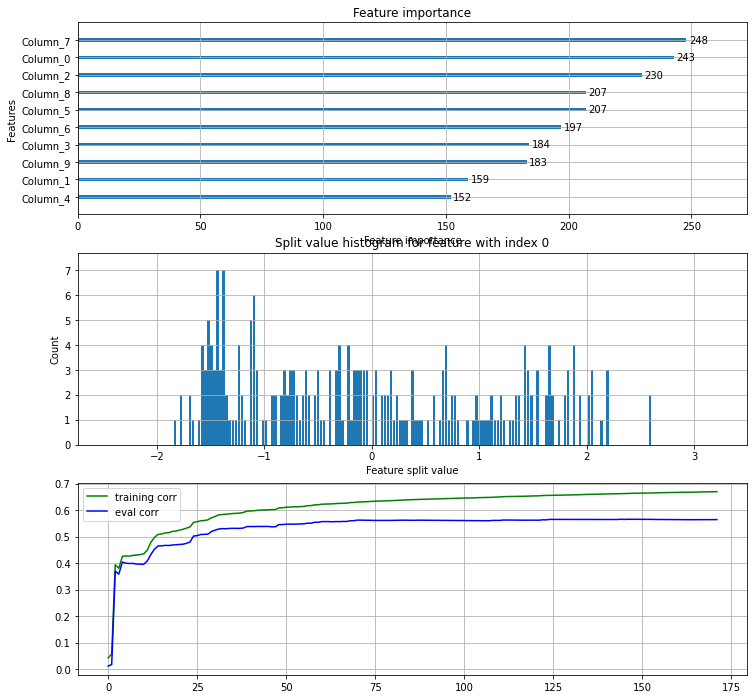

In [127]:
model_new = all_same_model(train_features, train_labels, 
                test_features, test_labels, 
                booster_params=booster_params, model_name='asset0', plot=True, cv=False, cv_params=cv_params)

In [122]:
with open('same_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [109]:
model

LGBMRegressor(boosting='gbdt', early_stopping_round=10,
              feature_fraction=0.2474220728597596,
              feature_fraction_bynode=0.5180331678983723,
              feature_fraction_seed=88, force_row_wise=True,
              learning_rate=0.6640838601230683,
              max_delta_step=0.29279831387314226, max_depth=7,
              min_data_in_leaf=72, n_estimators=37, num_leaves=29,
              objective='fair', reg_alpha=0.7236284236118263,
              reg_lambda=0.46647066913427127, seed=99,
              subsample=0.5428498915613255, tree_learner='data', verbose=-10)

In [29]:
with open('same_model.pkl', 'rb') as f:
    model = pickle.load(f)


In [128]:
# check oj simulator's result
def get_r_hat(A, B):
    features = data_preprocess(A, B, 30, 10, scaler_file='scaler.pkl')[0].values
    features = np.stack([features[-1,i::10] for i in range(10)], axis=0)
    preds = model_new.predict(features)
    return preds

import critic
cr = critic.Critic()
cr.submit(get_r_hat, log_pr.iloc[-1440*60:], volu.iloc[-1440*60:])

100%|██████████| 8496/8496 [06:36<00:00, 21.42it/s]


Total time used: 396.677s
Pairwise correlation:
	asset 0 = -0.03273
	asset 1 = 0.00171
	asset 2 = -0.00395
	asset 3 = -0.00259
	asset 4 = 0.02683
	asset 5 = 0.01864
	asset 6 = -0.00071
	asset 7 = 0.01585
	asset 8 = 0.01597
	asset 9 = -0.04543
	mean correlation = -0.00064
Overall correlation: -0.00521
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(396.6774182319641,
 0   -0.032728
 1    0.001714
 2   -0.003946
 3   -0.002593
 4    0.026826
 5    0.018644
 6   -0.000710
 7    0.015854
 8    0.015973
 9   -0.045426
 dtype: float64,
 -0.00520656884722368)